# Dataset

https://alt.qcri.org/semeval2016/task5/index.php?id=data-and-tools

In [1]:
from src.data.load_semeval import load_bytes, get_data

In [2]:
train = get_data(load_bytes('https://huggingface.co/datasets/hienbm/SemEval-2016/resolve/main/restaurants_russian_training.xml'))
test = get_data(load_bytes('https://huggingface.co/datasets/hienbm/SemEval-2016/resolve/main/restaurants_russian_test.xml'))

100%|██████████████████████████████████████████████████████████████████████████| 1209/1209 [00:00<00:00, 402229.99it/s]


In [415]:
train = train.with_columns(pl.col('text').rank('dense').alias('id'))
test = test.with_columns(pl.col('text').rank('dense').alias('id'))

In [416]:
train.head()

id,text,target,category,polarity,start,end
u32,str,str,str,str,str,str
1534,"""Обслуживание х…","""Обслуживание""","""SERVICE#GENERA…","""positive""","""0""","""12"""
1534,"""Обслуживание х…","""метрдотель""","""SERVICE#GENERA…","""positive""","""34""","""44"""
1601,"""Он был в уютно…","""уголке""","""AMBIENCE#GENER…","""positive""","""16""","""22"""
1601,"""Он был в уютно…","""приглушенный с…","""AMBIENCE#GENER…","""positive""","""46""","""63"""
1290,"""На наш не боль…","""блюд""","""FOOD#QUALITY""","""positive""","""53""","""57"""


In [428]:
test.head()

id,text,target,category,polarity,start,end
u32,str,str,str,str,str,str
586,"""Очень милый, у…","""ресторанчик""","""AMBIENCE#GENER…","""positive""","""20""","""31"""
586,"""Очень милый, у…","""порции""","""FOOD#STYLE_OPT…","""positive""","""64""","""70"""
586,"""Очень милый, у…","""порции""","""FOOD#PRICES""","""positive""","""64""","""70"""
586,"""Очень милый, у…","""блюд""","""FOOD#QUALITY""","""positive""","""82""","""86"""
738,"""Салаты со свеж…","""Салаты""","""FOOD#QUALITY""","""positive""","""0""","""6"""


# BERT ATE

In [4]:
import torch

from tqdm import tqdm
from transformers import BertModel, AutoTokenizer
from torch.utils.data import DataLoader
from torch import nn
from src.models import ATE

C:\Users\ibragimov_r\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-conversational')
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-conversational')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print()

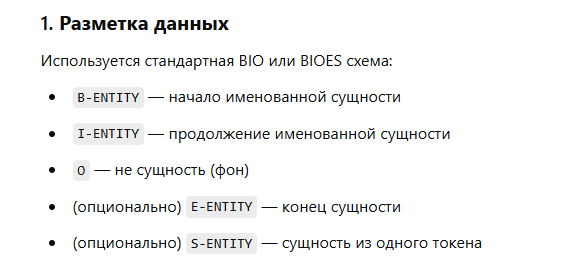

In [7]:
train_ds = ATE.TrainDataset(train, tokenizer)
test_ds = ATE.TrainDataset(test, tokenizer)
train_example = train_ds[4]

for i in range(len(train_example['input_ids'])):
    print(f"{tokenizer.convert_ids_to_tokens(train_example['input_ids'][i]):<15} {train_example['labels'][i]}")

[CLS]           -100
Гар             0
##дероб         0
##а             0
в               0
заведении       0
нет             0
,               0
зато            0
есть            0
напол           0
##ь             0
##ные           0
вешал           0
##ки            0
)               0
.               0
через           0
несколько       0
минут           0
к               0
нам             0
подошел         0
официант        1
с               0
меню            0
.               0
[SEP]           -100


In [8]:
train_dl = DataLoader(train_ds, collate_fn=ATE.collate_fn, batch_size=5)
test_dl = DataLoader(test_ds, collate_fn=ATE.collate_fn, batch_size=5)

In [9]:
N_EPOCH = 10

model_NER = ATE.BertForTokenClassification(bert=model)
criterion = nn.CrossEntropyLoss(ignore_index=-100, weight=torch.tensor([0.2, 0.4, 0.4], device=device))
optimizer = torch.optim.Adam(params=model_NER.parameters(), lr=1e-5)

In [10]:
for n_epoch in range(N_EPOCH):
    model.train()
    train_loss = 0
    for batch in tqdm(train_dl):
        out = model_NER(**batch)
        loss = criterion(out.view(-1, 3), batch['labels'].view(-1))
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
        train_loss += loss.detach().item()
    print(f'{n_epoch + 1} epoch. Train loss: {train_loss / len(train_dl)}')
    ATE.test_model(model_NER, test_dl)
    torch.save(model_NER, f"./artifacts/model_NER_{n_epoch}.pth")
    # scheduler.step()

100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:50<00:00, 10.87it/s]


1 epoch. Train loss: 0.20488689201790328


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 54.52it/s]




              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     13786
         1.0       0.73      0.87      0.80       952
         2.0       0.65      0.90      0.76       888

    accuracy                           0.94     15626
   macro avg       0.79      0.91      0.84     15626
weighted avg       0.95      0.94      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:50<00:00, 10.92it/s]


2 epoch. Train loss: 0.08413354375176609


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 53.69it/s]




              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     13786
         1.0       0.73      0.88      0.80       952
         2.0       0.69      0.87      0.77       888

    accuracy                           0.95     15626
   macro avg       0.80      0.90      0.85     15626
weighted avg       0.95      0.95      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:50<00:00, 10.88it/s]


3 epoch. Train loss: 0.047202774538263555


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 53.64it/s]




              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     13786
         1.0       0.71      0.90      0.80       952
         2.0       0.69      0.88      0.78       888

    accuracy                           0.95     15626
   macro avg       0.80      0.91      0.85     15626
weighted avg       0.95      0.95      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:49<00:00, 10.96it/s]


4 epoch. Train loss: 0.025791522383256143


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 55.00it/s]




              precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     13786
         1.0       0.70      0.90      0.79       952
         2.0       0.70      0.86      0.77       888

    accuracy                           0.95     15626
   macro avg       0.80      0.90      0.84     15626
weighted avg       0.95      0.95      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:48<00:00, 11.17it/s]


5 epoch. Train loss: 0.017872251158168793


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 55.88it/s]




              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     13786
         1.0       0.74      0.88      0.80       952
         2.0       0.75      0.82      0.79       888

    accuracy                           0.95     15626
   macro avg       0.83      0.89      0.85     15626
weighted avg       0.96      0.95      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:48<00:00, 11.19it/s]


6 epoch. Train loss: 0.009437108780386163


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 53.85it/s]




              precision    recall  f1-score   support

         0.0       0.98      0.97      0.98     13786
         1.0       0.79      0.86      0.82       952
         2.0       0.76      0.82      0.79       888

    accuracy                           0.96     15626
   macro avg       0.85      0.88      0.86     15626
weighted avg       0.96      0.96      0.96     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:49<00:00, 11.07it/s]


7 epoch. Train loss: 0.011542119039738698


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 52.40it/s]




              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     13786
         1.0       0.75      0.88      0.81       952
         2.0       0.76      0.82      0.79       888

    accuracy                           0.95     15626
   macro avg       0.83      0.89      0.86     15626
weighted avg       0.96      0.95      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:50<00:00, 10.93it/s]


8 epoch. Train loss: 0.007020059171382494


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 50.44it/s]




              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97     13786
         1.0       0.76      0.86      0.81       952
         2.0       0.75      0.80      0.78       888

    accuracy                           0.95     15626
   macro avg       0.83      0.88      0.85     15626
weighted avg       0.95      0.95      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:53<00:00, 10.24it/s]


9 epoch. Train loss: 0.006302621101540902


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 54.75it/s]




              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     13786
         1.0       0.72      0.90      0.80       952
         2.0       0.76      0.80      0.78       888

    accuracy                           0.95     15626
   macro avg       0.82      0.89      0.85     15626
weighted avg       0.95      0.95      0.95     15626



100%|████████████████████████████████████████████████████████████████████████████████| 547/547 [00:49<00:00, 11.05it/s]


10 epoch. Train loss: 0.0036002260456926343


100%|████████████████████████████████████████████████████████████████████████████████| 182/182 [00:03<00:00, 55.66it/s]




              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97     13786
         1.0       0.73      0.89      0.80       952
         2.0       0.72      0.84      0.77       888

    accuracy                           0.95     15626
   macro avg       0.81      0.90      0.85     15626
weighted avg       0.95      0.95      0.95     15626



In [22]:
model_NER = torch.load("./artifacts/model_NER_3.pth")

In [23]:
def inference(text):
    with torch.no_grad():
        tokens = tokenizer(text)
        tokens_batched = {k: torch.tensor(v, device=device).unsqueeze(0) for k, v in tokens.items()}
        output = model_NER(**tokens_batched).argmax(dim=2)[0].cpu()
        for i in range(len(tokens['input_ids'])):
            print(f"{tokenizer.convert_ids_to_tokens(tokens['input_ids'][i]):<15} {output[i]}")

In [24]:
inference('Когда я пришла в магазин, меня остановил охранник. Не знаю, что ему там показалось, но настроение было испорчено. Плюс приложение показалось очень тормозным')

[CLS]           0
Когда           0
я               0
пришла          0
в               0
магазин         0
,               0
меня            0
остановил       0
охранник        1
.               0
Не              0
знаю            0
,               0
что             0
ему             0
там             0
показалось      0
,               0
но              0
настроение      0
было            0
испор           0
##чено          0
.               0
Плюс            0
приложение      1
показалось      0
очень           0
тормоз          0
##ным           0
[SEP]           0


# BERT SPC

In [27]:
import torch

from tqdm import tqdm
from transformers import BertModel, AutoTokenizer
from torch.utils.data import DataLoader
from torch import nn
from src.models import SPC

In [28]:
train.head()

id,text,target,category,polarity,start,end
str,str,str,str,str,str,str
"""27925""","""Обслуживание х…","""Обслуживание""","""SERVICE#GENERA…","""positive""","""0""","""12"""
"""27925""","""Обслуживание х…","""метрдотель""","""SERVICE#GENERA…","""positive""","""34""","""44"""
"""27925""","""Он был в уютно…","""уголке""","""AMBIENCE#GENER…","""positive""","""16""","""22"""
"""27925""","""Он был в уютно…","""приглушенный с…","""AMBIENCE#GENER…","""positive""","""46""","""63"""
"""27925""","""На наш не боль…","""блюд""","""FOOD#QUALITY""","""positive""","""53""","""57"""


In [29]:
train["polarity"].value_counts()

polarity,counts
str,u32
"""positive""",3103
"""neutral""",276
"""negative""",709
"""conflict""",1


In [30]:
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased-conversational')
model = BertModel.from_pretrained('DeepPavlov/rubert-base-cased-conversational')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased-conversational were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print()

In [32]:
train_ds = SPC.TrainDataset(train, tokenizer)
test_ds = SPC.TrainDataset(test, tokenizer)

train_ds[0]

{'input_ids': [101, 2808, 70291, 7720, 1159, 18992, 21160, 42066, 1644, 322, 12150, 849, 42177, 303, 1318, 4065, 1517, 2361, 1721, 132, 102, 2808, 70291, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': 2}

In [33]:
train_dl = DataLoader(train_ds, collate_fn=SPC.collate_fn, batch_size=10, shuffle=True)
test_dl = DataLoader(test_ds, collate_fn=SPC.collate_fn, batch_size=10)

In [34]:
N_EPOCH = 10
NUM_CLASSES = 3

model_CLF = SPC.BertForAspectClassification(bert=model, num_labels=NUM_CLASSES, freeze_bert=False)
criterion = nn.CrossEntropyLoss(weight=torch.tensor([0.4, 0.4, 0.2], device=device))
optimizer = torch.optim.Adam(params=model_CLF.parameters(), lr=1e-5)

In [35]:
for n_epoch in range(N_EPOCH):
    model.train()
    train_loss = 0
    for batch in tqdm(train_dl):
        out = model_CLF(**batch)
        loss = criterion(out.view(-1, NUM_CLASSES), batch['labels'].view(-1))
        optimizer.zero_grad()
        loss.sum().backward()
        optimizer.step()
        train_loss += loss.detach().item()
    SPC.test_model(model_CLF, test_dl)
    torch.save(model_CLF, f"./artifacts/model_CLF_{n_epoch}.pth")
    print(f'{n_epoch + 1} epoch. Train loss: {train_loss / len(train_dl)}')

100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.58it/s]




              precision    recall  f1-score   support

         0.0       0.79      0.81      0.80       321
         1.0       0.51      0.42      0.46       103
         2.0       0.89      0.91      0.90       870

    accuracy                           0.84      1294
   macro avg       0.73      0.71      0.72      1294
weighted avg       0.84      0.84      0.84      1294

1 epoch. Train loss: 0.6330263851287895


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.61it/s]




              precision    recall  f1-score   support

         0.0       0.79      0.84      0.82       321
         1.0       0.74      0.19      0.31       103
         2.0       0.89      0.94      0.91       870

    accuracy                           0.86      1294
   macro avg       0.81      0.66      0.68      1294
weighted avg       0.85      0.86      0.84      1294

2 epoch. Train loss: 0.3489116454282935


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 28.73it/s]




              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       321
         1.0       0.58      0.44      0.50       103
         2.0       0.91      0.94      0.93       870

    accuracy                           0.87      1294
   macro avg       0.78      0.74      0.76      1294
weighted avg       0.87      0.87      0.87      1294

3 epoch. Train loss: 0.20229277840171073


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.32it/s]




              precision    recall  f1-score   support

         0.0       0.88      0.78      0.83       321
         1.0       0.38      0.77      0.51       103
         2.0       0.94      0.87      0.90       870

    accuracy                           0.84      1294
   macro avg       0.74      0.81      0.75      1294
weighted avg       0.88      0.84      0.85      1294

4 epoch. Train loss: 0.12782159703499058


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.59it/s]




              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       321
         1.0       0.46      0.51      0.49       103
         2.0       0.92      0.92      0.92       870

    accuracy                           0.86      1294
   macro avg       0.75      0.75      0.75      1294
weighted avg       0.87      0.86      0.87      1294

5 epoch. Train loss: 0.08033971148793538


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.57it/s]




              precision    recall  f1-score   support

         0.0       0.90      0.74      0.82       321
         1.0       0.56      0.37      0.44       103
         2.0       0.87      0.97      0.92       870

    accuracy                           0.86      1294
   macro avg       0.78      0.69      0.73      1294
weighted avg       0.86      0.86      0.85      1294

6 epoch. Train loss: 0.059022617586694824


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.45it/s]




              precision    recall  f1-score   support

         0.0       0.81      0.88      0.84       321
         1.0       0.57      0.45      0.50       103
         2.0       0.92      0.92      0.92       870

    accuracy                           0.87      1294
   macro avg       0.77      0.75      0.75      1294
weighted avg       0.87      0.87      0.87      1294

7 epoch. Train loss: 0.06770522255919564


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.26it/s]




              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84       321
         1.0       0.60      0.31      0.41       103
         2.0       0.89      0.95      0.92       870

    accuracy                           0.87      1294
   macro avg       0.78      0.70      0.72      1294
weighted avg       0.86      0.87      0.86      1294

8 epoch. Train loss: 0.03140188364809024


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.50it/s]




              precision    recall  f1-score   support

         0.0       0.87      0.78      0.82       321
         1.0       0.51      0.44      0.47       103
         2.0       0.90      0.95      0.92       870

    accuracy                           0.86      1294
   macro avg       0.76      0.72      0.74      1294
weighted avg       0.86      0.86      0.86      1294

9 epoch. Train loss: 0.03128118349098621


100%|████████████████████████████████████████████████████████████████████████████████| 130/130 [00:04<00:00, 29.54it/s]




              precision    recall  f1-score   support

         0.0       0.79      0.90      0.84       321
         1.0       0.61      0.42      0.50       103
         2.0       0.93      0.92      0.93       870

    accuracy                           0.87      1294
   macro avg       0.78      0.75      0.76      1294
weighted avg       0.87      0.87      0.87      1294

10 epoch. Train loss: 0.0373853976198718


# YandexGPT ATE zero shot

In [31]:
import requests

OAUTH_TOKEN = ''

resp = requests.post('https://iam.api.cloud.yandex.net/iam/v1/tokens', params={"yandexPassportOauthToken":f"{OAUTH_TOKEN}"})
IAM_TOKEN = resp.json()['iamToken']

In [32]:
folder_id = ''

In [27]:
system_promt = "Ты профессиональный разметчик данных для задач машинного обучения. Разметь данные для задачи Aspect Based Sentiment Analysis. Тебе необходимо найти аспект в отзыве и определить его полярность. Отвечай в формате: {aspect: sentiment_polarity}. Сохраняй форму слова как в тексте. Доступные варианты sentiment_polarity: позитивный, нейтральный, негативный. Если аспекта нет, оставляй пустое поле: {}"

In [41]:
import requests
import argparse
import polars as pl

URL = "https://llm.api.cloud.yandex.net/foundationModels/v1/completion"

def run(iam_token, folder_id, user_text):    
    # Собираем запрос
    data = {}
    # Указываем тип модели
    data["modelUri"] = f"gpt://{folder_id}/yandexgpt-lite/latest"
    # Настраиваем опции
    data["completionOptions"] = {"temperature": 0.3, "maxTokens": 1000}
    # Указываем контекст для модели
    data["messages"] = [
        {"role": "system", "text": system_promt},
        {"role": "user", "text": f"{user_text}"},
    ]
    
    # Отправляем запрос
    response = requests.post(
        URL,
        headers={
            "Accept": "application/json",
            "Authorization": f"Bearer {iam_token}"
        },
        json=data,
    ).json()

    return response

In [39]:
test_gpt = test.group_by('id', 'text').agg([i for i in test.columns if i not in ('id', 'text')])

In [70]:
ids = []
texts = []
answers = []
tokens_count = []

for row in tqdm(test_gpt.iter_rows(), total=test_gpt.shape[0]):
    ids.append(row[0])
    texts.append(row[1])
    result = run(IAM_TOKEN, folder_id, row[1])
    answers.append(result['result']['alternatives'][0]['message']['text'])
    tokens_count.append(int(result['result']['usage']['totalTokens']))
    
test_gpt_answers = pl.DataFrame({
    'id': ids,
    'text': texts,
    'gpt_answers': answers,
    'tokens_count': tokens_count
})

100%|████████████████████████████████████████████████████████████████████████████████| 908/908 [05:47<00:00,  2.61it/s]


In [171]:
print(f"Стоимость: {test_gpt_answers['tokens_count'].sum() / 1000 * 0.2} рублей")

Стоимость: 20.723 рублей


In [78]:
test_gpt_answers.write_parquet('test_gpt_answers.paquet')

In [188]:
polarity_mapping = {
    "позитивный": "positive",
    "негативный": "negative",
    "нейтральный": "neutral",
}

def try_eval(x):
    if x == "{}":
        return {}
    try:
        words = []
        polarity = []
        x = x.replace('\n', '')
        for aspects in x.split("}{"):
            words.append(aspects.split(":")[0].strip().replace("{", ""))
            polarity.append(polarity_mapping.get(aspects.split(":")[1].strip().replace("}", "")))
        return (words, polarity)
    except:
        return {}

In [189]:
test_gpt_answers = test_gpt_answers.with_columns(pl.col('gpt_answers').map_elements(try_eval).alias('raw'))

In [367]:
import re

def find_sentiment_offset(struct):
    try:
        target_normal_form = morph.parse(struct['target'])[0].normal_form
        for word in struct['text'].split():
            for i in """'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~']""":
                word = word.replace(i, "") 
            word_normal_form = morph.parse(word)[0].normal_form
            if target_normal_form == word_normal_form:
                span = re.search(word, struct['text'], re.IGNORECASE).span()
                if len(span) > 0:
                    return span
        span = re.search(struct['target'], struct['text'], re.IGNORECASE).span()
        return span if len(span) > 0 else [0, 0]
    except Exception as e:
#         print(e)
        return None

In [ ]:
test_gpt_answers = test_gpt_answers.with_columns(pl.col('raw').map_elements(lambda x: x[0]).alias('target'),
                                                  pl.col('raw').map_elements(lambda x: x[1]).alias('polarity'))

In [211]:
test_gpt_answers = test_gpt_answers.explode(['target', 'polarity']).drop('raw')

In [371]:
test_gpt_answers = test_gpt_answers.with_columns(pl.struct([pl.col('text'), pl.col('target')]).map_elements(find_sentiment_offset).alias('span'))

In [372]:
test_gpt_answers = test_gpt_answers.with_columns(pl.when(pl.col('span').list.len() < 2).then([0, 0]).otherwise(pl.col('span')).alias('span'))

In [373]:
test_gpt_answers = test_gpt_answers.with_columns(pl.col('span').map_elements(lambda x: x[0]).alias('start'),
                                                  pl.col('span').map_elements(lambda x: x[1]).alias('end'))

In [464]:
def get_labels(df, idx):
    row = df.filter(df['id'] == idx).row(0, named=True)
    encoding = tokenizer(row['text'], return_offsets_mapping=True)
    labels = [0] * len(encoding['input_ids'])

    for start, end, target in zip(row['start'], row['end'], row['target']):
        if target != "NULL":
            for n, border in enumerate(encoding['offset_mapping']):
                if sum(border) > 0:
                    if border[0] == int(start) :
                        labels[n] = 1
                    elif border[0] > int(start) and border[1] <= int(end):
                        labels[n] = 2
    return labels

In [375]:
test_gpt_answers_grouped = test_gpt_answers.group_by('id', 'text').agg([i for i in test_gpt_answers.columns if i not in ('id', 'text')])

In [438]:
# test_gpt_answers_grouped = test_gpt_answers_grouped.join(test.select(['id', 'text']).unique(), on='text').drop('id').rename({'id_right': 'id'})

In [445]:
test_gpt_answers_grouped = test_gpt_answers_grouped.sort('id')
test_grouped = test_grouped.sort('id')

In [475]:
print('Разметка YandexGPT', end='\n\n')
for t, l in zip([tokenizer.convert_ids_to_tokens(i) for i in tokenizer(test_gpt_answers_grouped.filter(pl.col('id') == 1)['text'].item())['input_ids']], 
                get_labels(test_gpt_answers_grouped, 1)):
    print(f'{t:<15} {l}')

Разметка YandexGPT

[CLS]           0
"               0
Крем            0
-               0
суп             0
из              0
белых           0
грибов          0
"               0
-               0
вкусно          1
,               0
рекомендую      0
,               0
понравилось     0
всем            0
трои            0
##м             0
:               0
)               0
[SEP]           0


In [476]:
print('Разметка ассесоров', end='\n\n')
for t, l in zip([tokenizer.convert_ids_to_tokens(i) for i in tokenizer(test_grouped.filter(pl.col('id') == 1)['text'].item())['input_ids']], 
                get_labels(test_grouped, 1)):
    print(f'{t:<15} {l}')

Разметка ассесоров

[CLS]           0
"               0
Крем            1
-               2
суп             2
из              2
белых           2
грибов          2
"               0
-               0
вкусно          0
,               0
рекомендую      0
,               0
понравилось     0
всем            0
трои            0
##м             0
:               0
)               0
[SEP]           0


In [477]:
for row in test_grouped.iter_rows():
    print(row)
    print(get_labels(test_grouped, row[0]))
    print(get_labels(test_gpt_answers_grouped, row[0]))
    break

(1, '"Крем-суп из белых грибов" - вкусно, рекомендую, понравилось всем троим :)', ['Крем-суп из белых грибов'], ['FOOD#QUALITY'], ['positive'], ['1'], ['25'])
[0, 0, 1, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [478]:
y_true = []
y_pred_gpt = []
for row in test_grouped.iter_rows():
    y_true.extend(get_labels(test_grouped, row[0]))
    y_pred_gpt.extend(get_labels(test_gpt_answers_grouped, row[0]))

In [480]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_gpt))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     15594
           1       0.53      0.52      0.52       951
           2       0.60      0.36      0.45       888

    accuracy                           0.91     17433
   macro avg       0.69      0.61      0.64     17433
weighted avg       0.90      0.91      0.90     17433



# YandexGPT SPC zero shot

In [518]:
test_gpt_answers = test_gpt_answers.with_columns(pl.col('target').map_elements(lambda x: morph.parse(x)[0].normal_form).alias('normal_form'))
test = test.with_columns(pl.col('target').map_elements(lambda x: morph.parse(x)[0].normal_form).alias('normal_form'))

In [537]:
test_spc_merged = test.join(test_gpt_answers, on=['id', 'normal_form'])

In [553]:
test_spc_merged = test_spc_merged.filter(pl.col('polarity') != 'conflict')

In [557]:
y_true = []
y_pred_gpt = []
for row in test_spc_merged.iter_rows(named=True):
    if row['polarity_right'] and row['polarity']:
        y_true.append(row['polarity'])
        y_pred_gpt.append(row['polarity_right'])

In [558]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred_gpt))

              precision    recall  f1-score   support

    negative       0.88      0.87      0.88        97
     neutral       0.67      0.07      0.13        57
    positive       0.84      0.99      0.91       304

    accuracy                           0.85       458
   macro avg       0.80      0.64      0.64       458
weighted avg       0.83      0.85      0.80       458

